This code should analyze data using a Fixed Effects method.

Author: Simon Kirschberger
Partial Source:   Lost Stats. (n.d.). Fixed Effects in Linear Regression. LOST. Retrieved June 21, 2022, from https://lost-stats.github.io/Model_Estimation/OLS/fixed_effects_in_linear_regression.html


In [283]:
#import relevant libraries
import numpy as np
import pandas as pd
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_white
import scipy.stats

In [184]:
#import data
df_panel= pd.read_excel(r"C:\Users\Simon\Downloads\df_altman7.xlsx")

In [185]:
#Set filters
Altman_Lower_Bound = -30
Altman_Upper_Bound = 30
Customer_Minimum = 2
Undisclosed_Lower_Bound = 0.01
Undisclosed_Upper_Bound = 1
SCF_Lower_Bound = 0
SCF_Upper_Bound = 1
Year_Lower_Bound = 2017
Year_Upper_Bound = 2021
#Industry = ''
Country = ['Canada', 'France', 'United States of America', 'Germany', 'China',
       'Croatia', 'South Africa', 'United Kingdom', 'Japan', 'Taiwan',
       'Denmark', 'Cyprus', 'Netherlands', 'Austria', 'Switzerland',
       'Spain', 'Belgium', 'Sweden', 'Ireland; Republic of',
       'New Zealand', 'India', 'Peru', 'Israel', 'Russia', 'Tunisia',
       'Norway', 'Mexico', 'Bermuda', 'Australia', 'Brazil',
       'United Arab Emirates', 'Luxembourg', 'Jordan', 'Uruguay',
       'Poland', 'Singapore', 'Malaysia', 'Finland', 'Hong Kong',
       'Cayman Islands', 'Mauritius', 'Italy', 'Turkey', 'Chile',
       'Panama', 'Monaco', 'Korea; Republic (S. Korea)', 'Greece',
       'Sri Lanka', 'Vietnam', 'Colombia', 'Saudi Arabia', 'Indonesia',
       'Philippines', 'Jersey', 'Romania', 'Thailand', 'Pakistan',
       'Hungary', 'Egypt', 'Malta', 'Papua New Guinea', 'Qatar',
       'Kazakhstan', 'Nigeria', 'Kenya', 'Bahamas', 'Ukraine',
       'Argentina']

In [187]:
#Apply Filters
df_panel = df_panel[df_panel['Altman_Z'].between(Altman_Lower_Bound, Altman_Upper_Bound)]
df_panel = df_panel[df_panel['%_have_undisclosed_scf'].between(Undisclosed_Lower_Bound, Undisclosed_Upper_Bound)]
df_panel = df_panel[df_panel['Year'].between(Year_Lower_Bound, Year_Upper_Bound)]
df_panel = df_panel[df_panel['%_have_scf'].between(SCF_Lower_Bound, SCF_Upper_Bound)]
df_panel = df_panel[df_panel['new_customers'] >Customer_Minimum]
#df_panel = df_panel[df_panel['Industry'] ==Industry]
df_panel = df_panel[df_panel['Country'].isin(Country)]

In [188]:
#remove unnessecary columns
df_panel['percentage_have_undisclosed_scf']=df_panel['%_have_undisclosed_scf']
df_panel['percentage_have_scf']=df_panel['%_have_scf']
df_panel.drop(['Unnamed: 0', 'Unnamed: 0.1', 'new_customers', 'have_scf', 'disclose_scf', 'Year_Eikon_Helper', 'Z_is_error','Supplier_ID','%_have_undisclosed_scf','%_have_scf'] , axis=1, inplace=True)


In [245]:
#Combine the Industry and country to create a combination of columns over which will be iterated to create a dummy column matrix
df_panel['entity'] = df_panel['Industry']+df_panel['Country']

In [246]:
df_panel.head(3)

,Supplier_Name,Year,Altman_Z,Country,Industry,percentage_have_undisclosed_scf,percentage_have_scf,entity
5,2Crsi SA,2021,3.186334,France,"Computers, Phones & Household Electronics",0.250000,0.250000,"Computers, Phones & Household ElectronicsFrance"
11,4Sc AG,2021,3.149493,Germany,Biotechnology & Medical Research,0.333333,0.333333,Biotechnology & Medical ResearchGermany
31,AAR Corp,2020,5.434088,United States of America,Aerospace & Defense,0.071429,0.142857,Aerospace & DefenseUnited States of America


In [244]:
#Set multiindex
data = df_panel.set_index(['entity', 'Year'])

In [247]:
#inspect df
data.head(5)

Supplier_Name  \
entity                                             Year                     
Computers, Phones & Household ElectronicsFrance    2021          2Crsi SA   
Biotechnology & Medical ResearchGermany            2021            4Sc AG   
Aerospace & DefenseUnited States of America        2020          AAR Corp   
                                                   2021          AAR Corp   
Professional & Commercial ServicesUnited States... 2018  ACCO Brands Corp   

                                                         Altman_Z  \
entity                                             Year             
Computers, Phones & Household ElectronicsFrance    2021  3.186334   
Biotechnology & Medical ResearchGermany            2021  3.149493   
Aerospace & DefenseUnited States of America        2020  5.434088   
                                                   2021  7.061378   
Professional & Commercial ServicesUnited States... 2018  1.066228   

                                                                          Country  \
entity                                             Year                             
Computers, Phones & Household ElectronicsFrance    2021                    France   
Biotechnology & Medical ResearchGermany            2021                   Germany   
Aerospace & DefenseUnited States of America        2020  United States of America   
                                                   2021  United States of America   
Professional & Commercial ServicesUnited States... 2018  United States of America   

                                                                                          Industry  \
entity                                             Year                                              
Computers, Phones & Household ElectronicsFrance    2021  Computers, Phones & Household Electronics   
Biotechnology & Medical ResearchGermany            2021           Biotechnology & Medical Research   
Aerospace & DefenseUnited States of America        2020                        Aerospace & Defense   
                                                   2021                        Aerospace & Defense   
Professional & Commercial ServicesUnited States... 2018         Professional & Commercial Services   

                                                         percentage_have_undisclosed_scf  \
entity                                             Year                                    
Computers, Phones & Household ElectronicsFrance    2021                         0.250000   
Biotechnology & Medical ResearchGermany            2021                         0.333333   
Aerospace & DefenseUnited States of America        2020                         0.071429   
                                                   2021                         0.066667   
Professional & Commercial ServicesUnited States... 2018                         0.250000   

                                                         percentage_have_scf  
entity                                             Year                       
Computers, Phones & Household ElectronicsFrance    2021             0.250000  
Biotechnology & Medical ResearchGermany            2021             0.333333  
Aerospace & DefenseUnited States of America        2020             0.142857  
                                                   2021             0.133333  
Professional & Commercial ServicesUnited States... 2018             0.250000

In [256]:
#Set up FE model
FE = PanelOLS(data.Altman_Z, data[['percentage_have_scf']],
              entity_effects = True,
              time_effects=True,
              )

In [257]:
#Configure model
result = FE.fit(cov_type = 'clustered',
             cluster_entity=True,
              cluster_time=True
             )

In [258]:
#Print Results
print(result)
result.params

                          PanelOLS Estimation Summary                           
Dep. Variable:               Altman_Z   R-squared:                        0.0030
Estimator:                   PanelOLS   R-squared (Between):              0.1263
No. Observations:                5440   R-squared (Within):               0.0030
Date:                Wed, Jun 22 2022   R-squared (Overall):              0.0707
Time:                        17:44:02   Log-likelihood                -1.781e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.361
Entities:                         393   P-value                           0.0001
Avg Obs:                       13.842   Distribution:                  F(1,5042)
Min Obs:                       1.0000                                           
Max Obs:                       609.00   F-statistic (robust):             5.9877
                            

percentage_have_scf    2.340298
Name: parameter, dtype: float64

C:\Users\Simon\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


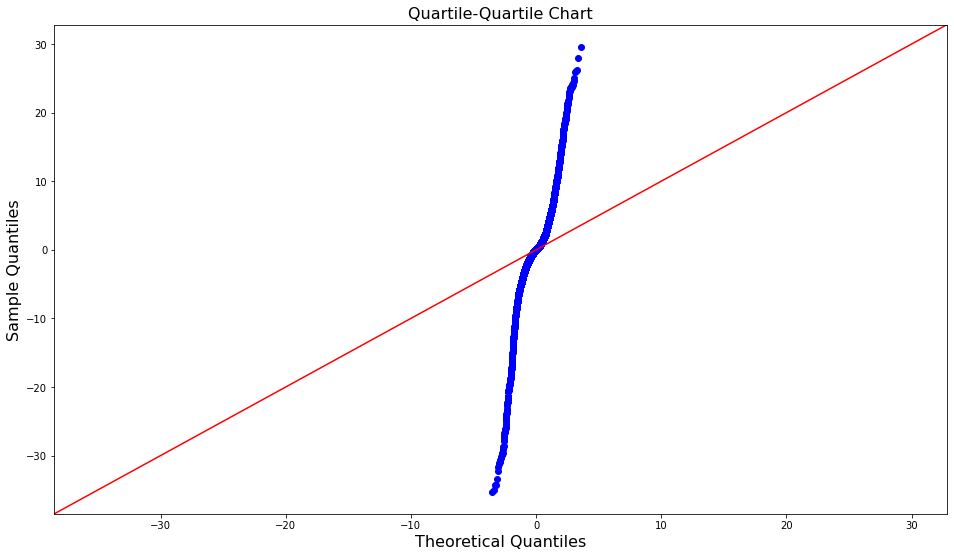

In [248]:
sm.qqplot(data=result.resids, line='45')
plt.xlabel("Theoretical Quantiles",  fontsize=16)
plt.ylabel("Sample Quantiles",  fontsize=16)
plt.title("Quartile-Quartile Chart" ,fontsize=16)
plt.rcParams["figure.figsize"] = (16,9)
#plt.savefig(r"C:\Users\Simon\Downloads\qq4.png", dpi=300,bbox_inches='tight')
plt.show()

In [294]:
scipy.stats.f.ppf(q=1-.05, dfn=1, dfd=2)

18.512820512820497